In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os

from utils import plot_histogram
from var import sc_data_folder, results_folder, today

<h4> 1. Loading data</h4>

In [6]:
#Create figures folder
figures_folder = os.path.join(results_folder, 'figures/cellranger_exploration/')
if not os.path.exists(figures_folder):
    os.makedirs(figures_folder)

In [7]:
#Read in sgRNA sequences to count reads per guide
sgrna_df=pd.read_csv(f'{sc_data_folder}cellranger710_count_05e682d5679826b9b76d6bec731bbe61/feature_reference.csv')
#Append additional sgRNA sequences that were not included in the data by appending rows to the dataframe
sgrna_rest_df = pd.DataFrame(
    [[
        "sgRNA1_SCP_CGAGTGTTCGATCGCGACTG_sgRNA1_SCP_CGAGTGTTCGATCGCGACTG_2",
        "sgRNA1_SCP_CGAGTGTTCGATCGCGACTG_sgRNA1_SCP_CGAGTGTTCGATCGCGACTG_2",
        "R2",
        "TGCTGTTTCCAGCATAGCTCTTAAAC(BC)",
        "AGTCGCGATCGAACACTCGC",
        "CRISPR Guide Capture"
        ],
    [
        "sgRNA6_SCP_GCAGACGTGCCTACGGACCG_sgRNA6_SCP_GCAGACGTGCCTACGGACCG_2",
        "sgRNA6_SCP_GCAGACGTGCCTACGGACCG_sgRNA6_SCP_GCAGACGTGCCTACGGACCG_2",
        "R2",
        "TGCTGTTTCCAGCATAGCTCTTAAAC(BC)",
        "CGGTCCGTAGGCACGTCTGC",
        "CRISPR Guide Capture"]],
    columns= sgrna_df.columns
)
#rowwise concatenation of the two dataframes
sgrna_df = pd.concat([sgrna_df, sgrna_rest_df], axis=0,ignore_index=True)

In [8]:
#Read in protospace call per cell file to dataframe
protospacer_df = pd.read_csv(f'{sc_data_folder}cellranger710_count_05e682d5679826b9b76d6bec731bbe61/crispr_analysis/protospacer_calls_per_cell.csv')


In [9]:
protospacer_df.sort_values(by=['num_umis'], inplace=True)

<h4> 2. Data exploration of guides per cell from cellranger</h4>

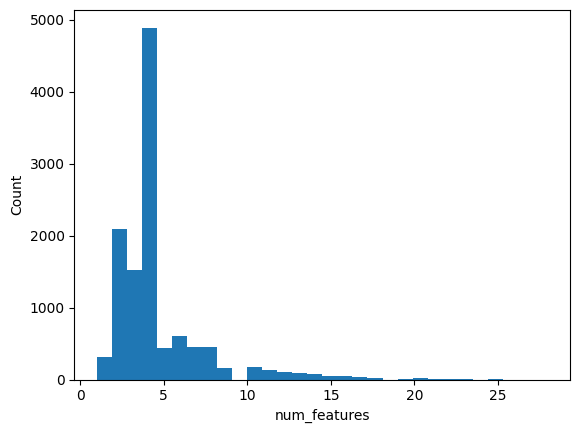

<Figure size 640x480 with 0 Axes>

In [10]:
#plot histogram of inital counts
plot_histogram(
    protospacer_df,
    'num_features',
    30,
    'num_features',
    'Count',
    f'{figures_folder}',
    today,
    'sgRNA_counts_per_cell_before_filtering')

In [11]:
#Create list from feature call and numeric umis assignment which should be split by "|"
protospacer_df['feature_call_split']=protospacer_df['feature_call'].str.split('|')
protospacer_df['num_umis_split']=protospacer_df['num_umis'].str.split('|')
#map guide counts/cell to barcodes
protospacer_counts=[dict(zip(a,b)) for a,b in zip(protospacer_df.feature_call_split,protospacer_df.num_umis_split)]
#convert list of dictionnary to dataframe
protospacer_counts_df=pd.DataFrame(protospacer_counts)
#convert to numeric
protospacer_counts_df=protospacer_counts_df.apply(pd.to_numeric, errors='coerce')
#entries in df smaller than 10 should be nan
protospacer_counts_df[protospacer_counts_df<10]=np.nan
#Concatenate protospacer counts to the protospacer dataframe
protospacer_counts_df=pd.concat([protospacer_df[['cell_barcode']],protospacer_counts_df],axis=1)


In [12]:
#transform protospacer_counts_df from wide to long format keeping the cell barcode and num_features as identifier
protospacer_counts_df_long=pd.melt(protospacer_counts_df,id_vars=['cell_barcode'],var_name='sgRNA',value_name='count')

In [13]:
protospacer_counts_df_long.set_index('cell_barcode')
#drop all the nans in the count column
protospacer_counts_df_long=protospacer_counts_df_long.dropna(subset=['count'])

In [14]:
#check the non intersecting elements between column name in sgrna_df and column sgrna protospacer_counts_df_long
missing_guides=np.setdiff1d(sgrna_df['name'],protospacer_counts_df_long['sgRNA'])
print(f'Guides which are not found in the screen: {missing_guides}')


Guides which are not found in the screen: ['AIRE_ACAGCAGCGCCTCCATCACA_AIRE_CGGAGACTTCCCGAGAGCGA_2'
 'DBX2_CCGTCCAGATCTGCATAGAG_DBX2_GTCCAGATCTGCATAGAGAG_1'
 'DBX2_CCGTCCAGATCTGCATAGAG_DBX2_GTCCAGATCTGCATAGAGAG_2'
 'DBX2_GCTCCCAGAGCCTACGCTGT_DBX2_GTTTCTCTGGCCGACAGCGT_1'
 'DBX2_GCTCCCAGAGCCTACGCTGT_DBX2_GTTTCTCTGGCCGACAGCGT_2'
 'DLX5_ACAAAGCATTGCTTAAAAAG_DLX5_GGGTGTTACTGTTGCTCCCG_1'
 'DLX5_CAAAGCATTGCTTAAAAAGG_DLX5_AAAACTAGTTGGACGAGTTA_1'
 'DLX5_CAAAGCATTGCTTAAAAAGG_DLX5_AAAACTAGTTGGACGAGTTA_2'
 'FOXN1_CCGGAGGGGCTGCGCCAAAA_FOXN1_TAAGAAGCTAGTTTGCTCCT_1'
 'FOXN1_CCGGAGGGGCTGCGCCAAAA_FOXN1_TAAGAAGCTAGTTTGCTCCT_2'
 'FOXN1_GGAGGGGCTGCGCCAAAACG_FOXN1_CGGAGGGGCTGCGCCAAAAC_1'
 'FOXN1_GGAGGGGCTGCGCCAAAACG_FOXN1_CGGAGGGGCTGCGCCAAAAC_2'
 'GATA2_ATCCCGGAGTGTTCGCAAGA_GATA2_CCTGCACAGACATGAAGCGG_1'
 'GATA2_ATCCCGGAGTGTTCGCAAGA_GATA2_CCTGCACAGACATGAAGCGG_2'
 'GATA2_GATCCCGGAGTGTTCGCAAG_GATA2_TTGGGCTTCTTAGGCGTGCG_1'
 'GATA2_GATCCCGGAGTGTTCGCAAG_GATA2_TTGGGCTTCTTAGGCGTGCG_2'
 'NEUROD2_ATTGGCATGCGTCTGCACTG

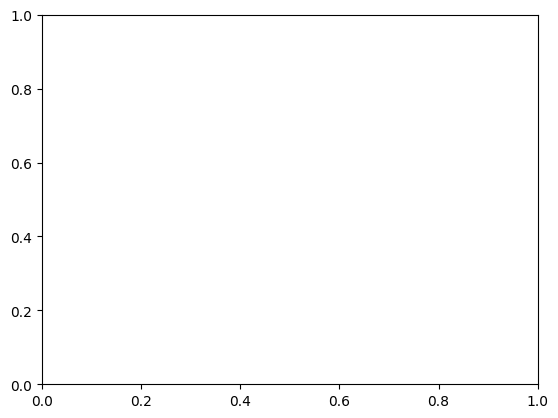

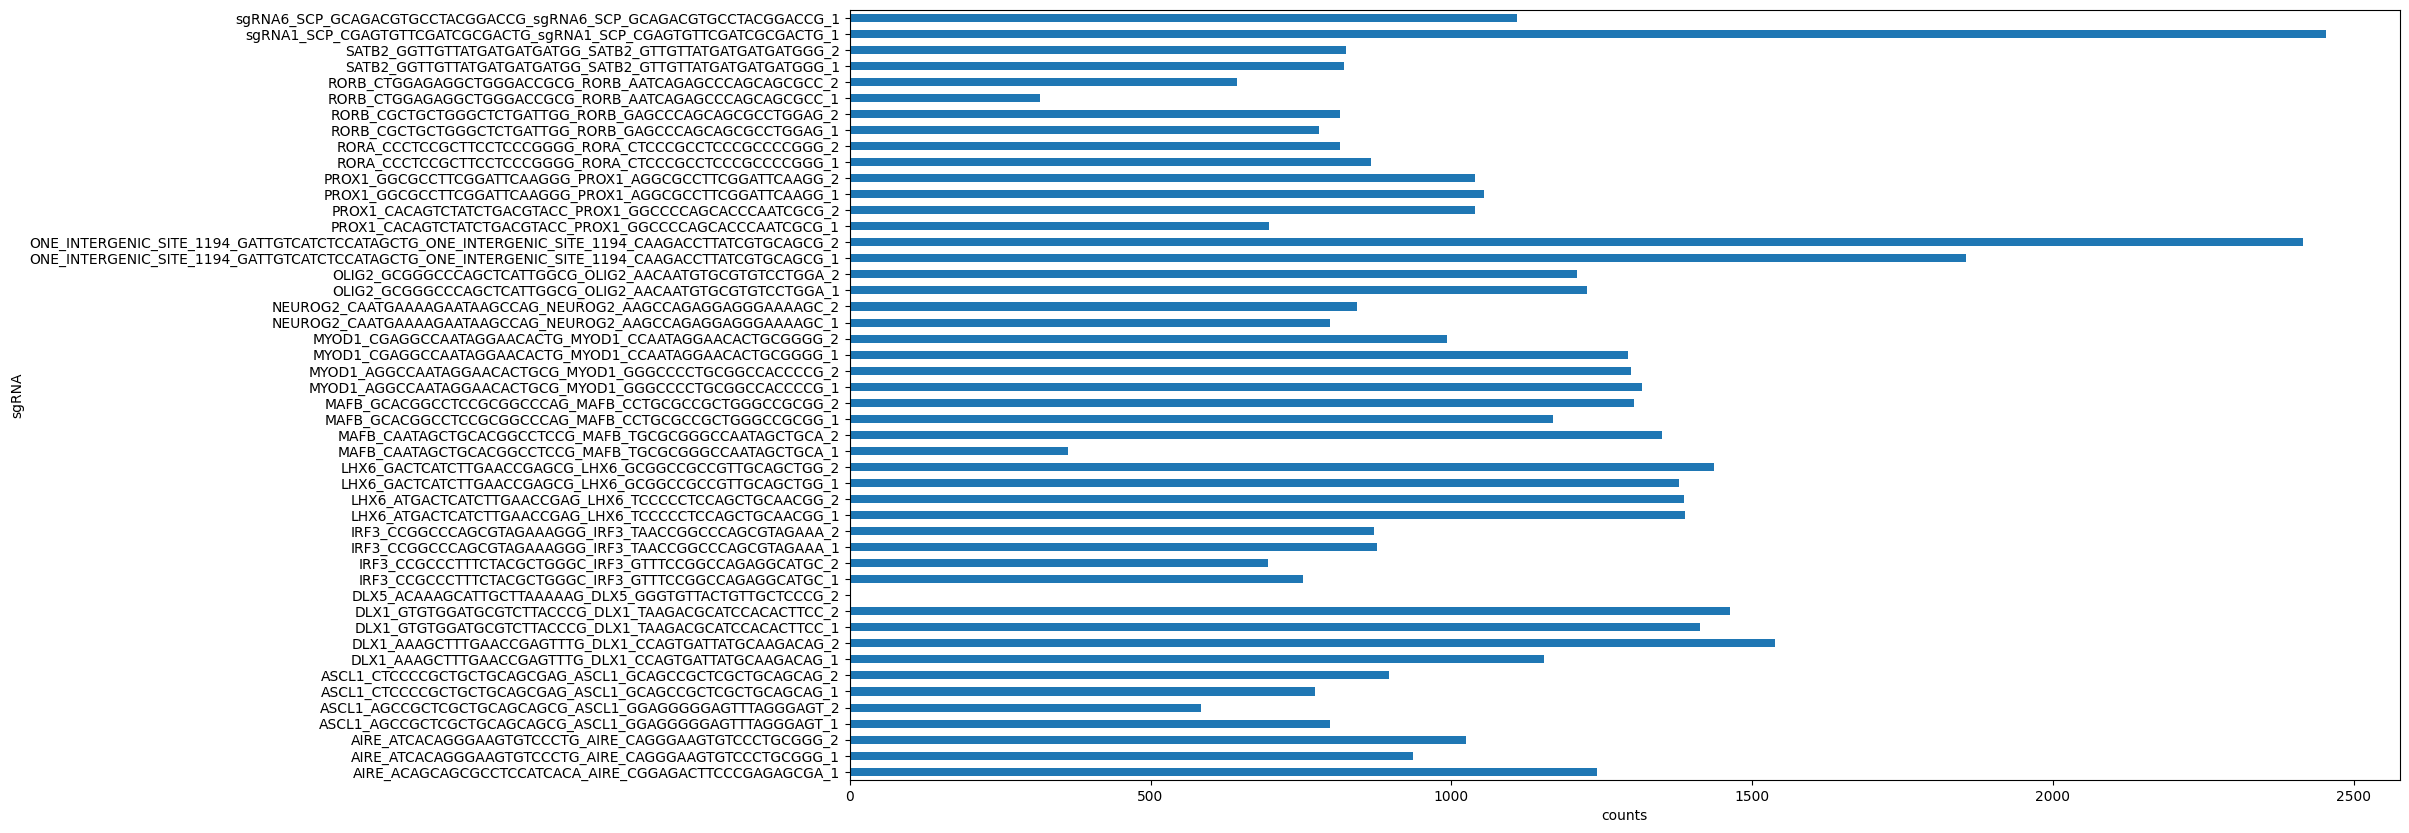

In [17]:
#count number of unique barcode per guide by counting the number of rows which are non nan
guides_per_cell_df=protospacer_counts_df_long.groupby('sgRNA').count()
#plot barplot to determine the number of guides per cell
fig,ax = plt.subplots();
ax=guides_per_cell_df.plot.barh(y='count',figsize=(20,10),legend=False);
ax.set_xlabel('counts');
fig.show()
plt.savefig(f'{figures_folder}{today}cell_per_guide.png')

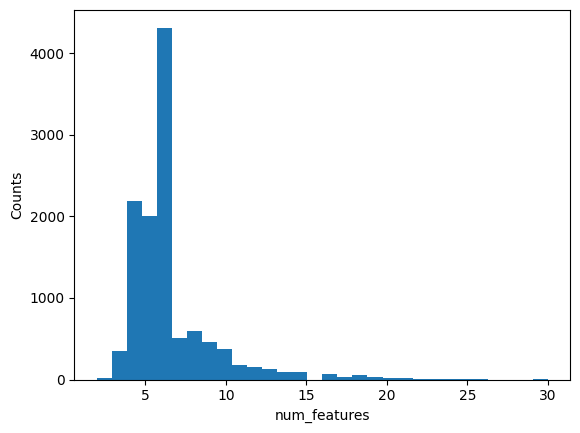

<Figure size 640x480 with 0 Axes>

In [25]:
#count number of columns per row with non nan entries
protospacer_counts_df['num_features']=protospacer_counts_df.count(axis=1)
#plot histogram of inital counts
plot_histogram(
    protospacer_counts_df,
    'num_features',
    30,
    'num_features',
    'Counts',
    f'{figures_folder}',
    today,
    'sgRNA_counts_per_cell_after_filtering')